In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Introduction

In this notebook we will investigate Logistic Regression on the Pima Indians Diabetes dataset (https://www.kaggle.com/uciml/pima-indians-diabetes-database) where we will try to predict the onset of Diabetes, based on certain diagnostics and measurements.

Begin by downloading, and importing the data set.

This will be followed by a short recap of logistic regression, and the training procedure. The first set of exercises will ask you to submit a short proof that the sigmoid function always lies between 0 and 1, and also to fit the data-set to a Logistic Regression model.

We then look at choosing the best model for classification. For this, we will consider the same variable selection as seen in the first notebook. We will then have a short introduction on regularization. This is a very important concept in Machine Learning, it can be used to avoid over-fitting, as well as for variable selection (which we will not cover). The second set of exercises consists in choosing the best regularization constant, and exploring its effect on the model.

Finally, we will look at *interpreting* the output of the model to make decisions. We do this by changing the probability thresholds for classification, and explain how we will choose them by considering risk of misclassification.

# Downloading and pre-processing the data

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We must then split the data into inputs and outputs. We also remove the Insulin variable, since the data is incomplete (there are ways of dealing with incomplete data, but that is not the purpose of this notebook).

In [3]:
outputs = ['Outcome']
inputs = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']

X = data[inputs]
Y = data[outputs].to_numpy().reshape(-1)

We will now scale the data. Can you explain why this step needs to be done?

In [4]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

Finally, we divide it into a 80 / 20 training and testing split.

In [5]:
num_of_points = len(Y)

idx = list(range(num_of_points))
np.random.shuffle(idx)
idx_train = idx[:int(num_of_points * 0.8)]
idx_train.sort()
idx_test = idx[int(num_of_points * 0.8):]
idx_test.sort()

X_train = X[idx_train, :]
X_test = X[idx_test, :]

Y_train = Y[idx_train]
Y_test = Y[idx_test]

# Logistic Regression

Recall that logistic regression is a model that is very well suited to problems where we have a binary output. That is, we are trying to use certain predictors to classify a particular input into one of two classes. We can write this down more formally.

Assume we have a set of predictors $x \in \mathcal{X}$, and a set of outputs $y \in \{0, 1 \}$. We are then interested in estimating the probability of belonging to a certain class, that is, we want to build an estimator, $\hat{p}(x)$, such that:
$$
\hat{p}(x) = \mathbb{P}( Y = 1 | X = x )
$$

There are many real-world scenarios where this might be the case. Consider for example, we might be interested in predicting if a particular individual infected with COVID will need hospital treatment. In this case, we would define $Y = 1$ the scenario where the individual requires treatment, and $Y = 0$ otherwise. For predictors we could use $X = $ age. 

We could decide to use linear regression, that is, a model of the form:
$$
\hat{p}(x) = \beta_0 + x \beta_1
$$

However, we run into trouble. Probabilities must lie between 0 and 1! The linear model is unable to incorporate this property into its predictions!

We can instead wrap our linear model in a function that guarantees all our outputs lie between 0 and 1. We will be using the sigmoid function, defined as:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

After wrapping the linear model, we obtain the logistic regression model, given by:
$$
\hat{p}(x) = \sigma(\beta_0 + x \beta_1)
$$

Which we can write as:
$$
\hat{p}(x) = \frac{e^{\beta_0 + x \beta_1}}{1 + e^{\beta_0 + x \beta_1}}
$$

# Training the function

The parameters of a linear regression model can be estimated using least squares. However, it is not the best optimiser for logistic regression. This is because we are not estimating $Y$ directly, instead we are estimating $\textit{the probability}$ of Y. This means maximum likelihood estimation is much more appropriate for logistic regression. We can write the likelihood function easily:
$$
\mathcal{L} = \prod_{i : y_i = 1} \mathbb{P}(Y = 1 | X = x_i) \prod_{i' : y_{i'} = 0} (1 - \mathbb{P}(Y = 0 | X = x_{i'}))
$$

Instead of maximising this directly, it is more common to minimise the negative log-likelihood:
$$
\ell(\beta) = - \log \mathcal{L}(\beta) = - \sum_{i : y_i = 1} \log\sigma(x_i^T \beta) - \sum_{i' : y_{i'} = 0}\log \sigma(x_{i'}^T\beta)
$$
So that we choose our parameters, $\hat{\beta}$:
$$
\hat{\beta} = \arg\min_{\beta} \ell(\beta)
$$

Finding the minimum can easily be done using any gradient-based optimiser. In addition, we can also add regularisation, which helps us avoid overfitting. We will begin by investigating this.

## Exercise 1:

1. Prove that the sigmoid function always gives an output between 0 and 1. (Hint: consider the limits as $x \rightarrow \pm \infty$, and show the function is always increasing).

2. Using scikit.learn's LogisticRegression class, train a model on the data-set above, make sure you are not regularising (read the sklearn's documentation! - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Show the model's training and test accuracy, and build a confusion matrix for each set. (Hint: the methods and functions required are $ \texttt{.fit()} $, $\texttt{.predict()}$, $\texttt{confusion\_matrix()}$, and $\texttt{accuracy\_score()}$.

## Solution

1. Note that as $x \rightarrow -\infty$, $\sigma(x) \rightarrow 0$ and as $x \rightarrow \infty$, $\sigma(x) \rightarrow 1$. Furthermore, the function is strictly increasing since the derivative is always positive. This means that $0 \leq f(x) \leq 1$ for any $x$! This makes the function very useful for our purposes.  

In [6]:
# define the model
model = LogisticRegression(penalty = 'none')
# train the model
model.fit(X_train, Y_train)
# create the predictions
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)
# build the confusion matrices
confusion_matrix_train = confusion_matrix(Y_train, Y_train_pred)
confusion_matrix_test = confusion_matrix(Y_test, Y_test_pred)
# calculate accuracies
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
# display the results
print('Training Confusion Matrix')
print(confusion_matrix_train)
print()
print(f'Training accuracy = {train_accuracy}')
print()
print('Testing Confusion Matrix')
print(confusion_matrix_test)
print()
print(f'Testing accuracy = {test_accuracy}')

Training Confusion Matrix
[[350  45]
 [ 90 129]]

Training accuracy = 0.7801302931596091

Testing Confusion Matrix
[[87 18]
 [20 29]]

Testing accuracy = 0.7532467532467533


## Excercise 2

Regularisation happens when we add a penalty to the loss function. We do this to decrease the complexity of the model, in an attempt to stop the model from over-fitting. Ideally, this should lead to better generalisation. To be more precise, for L2 regulatisation we will now choose our parameters by minimising the modified loss function:
$$
\hat{\beta} = \arg\min_\beta \{ C \cdot \ell(\beta) + \frac{1}{2}\beta^T \beta \}
$$

Note that the new penalisation means that $\beta$ should be closer to zero (this is what we mean by 'a simpler model').

Investigate the effect of L2 regulariastion. In particular, focus on the how the testing accuracy changes for different values of $C$. Create a plot that shows how $C$ varies, starting at $10^{-6}$ and ending at $10^{-2}$.

1. What behaviour do you observe as you increase regularisation (that is, as $C$ becomes small)?

2. From your investigation, choose the best regularisation constant. How does it compare with previous testing accuracy?

3. For which values of $C$ can you recover your previous training accuracy? Can you explain why does this happen?

## Solution

1. Our model will become too simple, and we will lose performance.

2. It is likely there is some improvement, but it is not necesarily the case. Assess on an individual basis.

3. We can recover the unregularised estimates for large enough $C$ values. This happens because the penalisation part of the loss will lose importance as $C$ increases.

Best test accuracy was achieved with C = 0.006039547738693467, giving an accuracy of 0.7792207792207793.
Without regularisation, we achieved an accuracy of 0.7532467532467533.



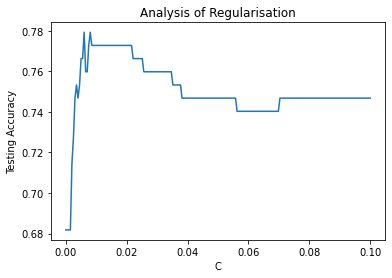

In [7]:

C_space = np.linspace(10e-6, 10e-2, 200)
accuracies = []

for C in C_space:
  model = LogisticRegression(penalty = 'l2', C = C)
  model.fit(X_train, Y_train)
  Y_test_pred = model.predict(X_test)
  accuracies.append(accuracy_score(Y_test, Y_test_pred))

plt.plot(C_space, accuracies)
plt.xlabel('C')
plt.ylabel('Testing Accuracy')
plt.title('Analysis of Regularisation')

best_model = np.argmax(accuracies)
best_accuracy = accuracies[best_model]
best_C = C_space[best_model]

print(f'Best test accuracy was achieved with C = {best_C}, giving an accuracy of {best_accuracy}.') 
print(f'Without regularisation, we achieved an accuracy of {test_accuracy}.')
print()

# Probability Thresholds

Recall that we are not estimating $Y$ directly, but instead the probability of $Y = 1 | X$. So far, our classification has been based on the which class has the higher probability. In other words, we have been using the classifier:
$$
  \hat{Y}(x) =
    \begin{cases}
      0 & \text{if } \hat{p}(x) < 0.5 \\
      1 & \text{if } \hat{p}(x) \geq 0.5 \\
    \end{cases}       
$$

However, we must also consider that the probability threshold of 0.5 might not be optimal. Indeed, consider our current data-set. Let's say we were going to use our model to decide who should go see a doctor and possibly get preventive treatment. In this case, incorrectly predicting that someone will not have Diabetes, when they will, is very costly - the person might face severe health consequences. On the other hand, incorrectly saying someone will have Diabetes, when they won't, is not as bad because the doctor would be able to catch this, and we would just waste a little time. 

This is one of the greatest strengths of logistic regression. The way we define and train them, mean we obtain good uncertainty estimates, so that we might make risk assessments!

## Exercise 3

1. Train a new logistic regression model, using the best regularisation constant you found in exercise 2.

2. Build a new function which takes as inputs: your Logistic Regression model, a set of $X$ values in which to predict, and a probability threshold $T_p$. The function should return an array of predictions based on the new probability threshold. (Hint:  use the $\texttt{predict\_proba}$ method in $\texttt{LogisticRegression}$)

3. Investigate the effect of the probability threshold on the number of False Negatives and False Positives. Based on this analysis, what probability threshold would YOU choose? What kind of information would you want to make such a decision?

## Solution

For this solution, we will simply create two plot, showing how the FNR gets smaller as we decrease the threshold. We will show the FPR increasing as this happens. Overall, the question of choosing a threshold will depend on the specific situations, and how risk-averse the individual making the model is.

In this particular case, we would seek to balance the risk of not treating people who will end up sick, and the risk of overwhelming the doctors which would treat them (by sending a lot of non-sick patients). 

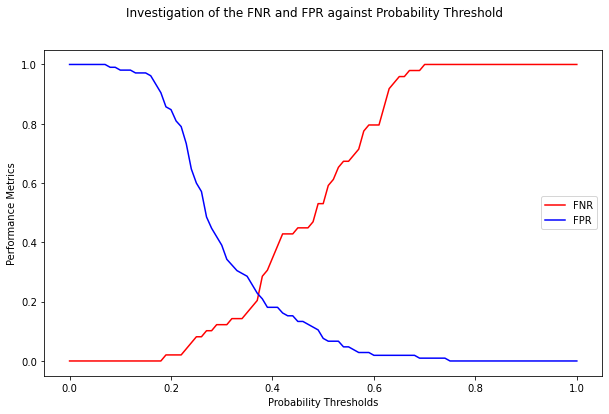

In [8]:
# define and train model
model = LogisticRegression(penalty = 'l2', C = best_C)
model.fit(X_train, Y_train)

def predict_with_threshold(model, X, threshold):
  # calculate the probabilites
  probabilites = model.predict_proba(X)
  # scikit returns the probabilities for each class. However, we only need the second column as there are only two classes
  # and probabilites add up to one. In particular, the second column represents Pr(Y = 1 | X)
  probabilites = probabilites[:, 1]
  # build an array of boolean variables, checking where our probabilities are larger or equal to the threshold
  boolean_threshold = (probabilites >= threshold)
  # since our class labels are 1 and 0, we can simply transform the boolean variables by making them integers
  predictions = boolean_threshold.astype(int)

  return predictions

# define threshold space, initialise lists
thresholds = np.linspace(0, 1, 101)

false_negatives = []
false_positives = []

# calculate number of true positives and negatives
num_of_positives = np.sum(Y_test)
num_of_negatives = len(Y_test) - num_of_positives

for tp in thresholds:
  # predict
  Y_pred = predict_with_threshold(model, X_test, tp)
  #calculate predictions
  cm = confusion_matrix(Y_test, Y_pred)
  # calculate false negative rate and false positive rate
  fnr = cm[1, 0] / num_of_positives
  fpr = cm[0, 1] / num_of_negatives
  # append to lists
  false_negatives.append(fnr)
  false_positives.append(fpr)

# create a plot to see how the rates change with the threshold
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Investigation of the FNR and FPR against Probability Threshold')

ax.plot(thresholds, false_negatives, 'r', label = 'FNR')
ax.plot(thresholds, false_positives, 'b', label = 'FPR')
ax.set_ylabel('Performance Metrics')
ax.set_xlabel('Probability Thresholds')
ax.legend()